<a href="https://colab.research.google.com/github/davideandres95/ml_comm/blob/main/tut07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Tutorial 7: Mapper
December 9, 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch            
from torch import nn, optim

##### Problem 6.1 - One hot mapping
Consider a mapper that maps a message $a \in \mathcal{A} = \{0,1, \dots, M-1 \}$  with $M = 2^m$ to a channel input alphabet 
$\mathcal{X} = \{x_0, x_1, \dots, x^{M-1}\}$,i.e., $a \mapsto x_a$. 
The channel input alphabet is fixed and given.
* 1) Let $u = \{u_1, u_2, \dots,  u_{M-1} \}$ be a one-hot representation of message a, i.e., $u_i(a) = 1(i =a)$. 
Show that a linear neuron with $M$ inputs can realize the mapping $u(a) \mapsto  x_a$,
$a \in \mathcal{A}$, for any input alphabet $\mathcal{A}$.


In [2]:
def one_hot(a, M):
    onehot = np.zeros(M)
    onehot[a] = 1
    return onehot


In [3]:
class Mapper(nn.Module):
    def __init__(self, alphabet):
        super().__init__()
        self.M = alphabet.size
        self.lin1 = nn.Linear(self.M, 1, bias=False) # set bias to zero
        self.lin1.weight = nn.Parameter(torch.Tensor([[i for i in alphabet]]).double()) # set weigths equal to alphabet values

    def forward(self, y):
        y = self.lin1(y)
        return y

In [4]:
M = 8
alphabet = np.array([-7, -5, -3, -1, 1, 3, 5, 7])
mapper = Mapper(alphabet)
messages = np.arange(M)

for i in messages:
    print('-------')
    print(f'Message: {i}')
    print(f'One-hot representation: {one_hot(i,M)}')
    t = torch.tensor(one_hot(i,M)).double()
    x = mapper(t)
    print(f'Neuron output: {x[0].detach()}')

-------
Message: 0
One-hot representation: [1. 0. 0. 0. 0. 0. 0. 0.]
Neuron output: -7.0
-------
Message: 1
One-hot representation: [0. 1. 0. 0. 0. 0. 0. 0.]
Neuron output: -5.0
-------
Message: 2
One-hot representation: [0. 0. 1. 0. 0. 0. 0. 0.]
Neuron output: -3.0
-------
Message: 3
One-hot representation: [0. 0. 0. 1. 0. 0. 0. 0.]
Neuron output: -1.0
-------
Message: 4
One-hot representation: [0. 0. 0. 0. 1. 0. 0. 0.]
Neuron output: 1.0
-------
Message: 5
One-hot representation: [0. 0. 0. 0. 0. 1. 0. 0.]
Neuron output: 3.0
-------
Message: 6
One-hot representation: [0. 0. 0. 0. 0. 0. 1. 0.]
Neuron output: 5.0
-------
Message: 7
One-hot representation: [0. 0. 0. 0. 0. 0. 0. 1.]
Neuron output: 7.0


* 2) For $M = 8$, sample the symbols in $\mathcal{X}$ uniform at random from the interval $[-8, 8]$
and train a linear neuron that realizes $u(a) \mapsto x_a$ using the MSE loss.

In [5]:
def classic_mapper(msg, alphabet):
    return alphabet[msg]

In [6]:
class Mapper2(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(M, 1)
        
    def forward(self, y):
        y = self.lin1(y)
        return y

In [15]:
# Create data 
n = 100000
a = np.random.choice(range(M), size=n) # messages 
x = classic_mapper(a, alphabet) # alphabeth symbols to be used as labels
onehot = np.array([one_hot(a[i], M) for i in range(n)]) # hot one representation to be used as inputs

In [16]:
# Initialize network
mapper2 = Mapper2(M)
# loss function
loss_fn = nn.MSELoss()
# Optimizer
optimizer = optim.Adam(mapper2.parameters(), lr=0.1)

In [18]:
x_t = torch.tensor(x.reshape(-1,1)).float()
onehot_t = torch.tensor(onehot).float()
# Training loop
for j in range(1000):
    x_hat = mapper2(onehot_t)
    loss = loss_fn(x_hat, x_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Printout and visualization
    if j % 100 == 0:
        print(f'epoch {j}: Loss = {loss.detach().numpy() :.4f}')

epoch 0: Loss = 20.9991
epoch 100: Loss = 0.0397
epoch 200: Loss = 0.0000
epoch 300: Loss = 0.0000
epoch 400: Loss = 0.0000
epoch 500: Loss = 0.0000
epoch 600: Loss = 0.0000
epoch 700: Loss = 0.0000
epoch 800: Loss = 0.0000
epoch 900: Loss = 0.0000


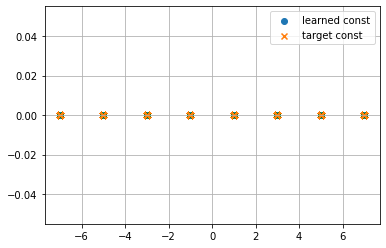

In [19]:
# Data for the plots
a_plot = np.arange(M)
x_plot = classic_mapper(a, alphabet)
onehot_plot = torch.tensor(np.array([one_hot(a_plot[i], M) for i in range(M)])).float()
xhat_plot = mapper2(onehot_plot).detach().numpy()
# Plot
plt.scatter(np.real(xhat_plot),np.imag(xhat_plot), marker="o",label='learned const')
plt.scatter(np.real(x_plot),np.imag(x_plot), marker='x', label='target const')

plt.legend()
plt.grid()

* 3) Let $\boldsymbol{b} = \{b_0, b_1, \dots, b_{m-1} \}$ be a binary representation of message $a$. Identify an input
alphabet $\mathcal{X}$ for which a linear neuron with $m$ inputs cannot realize the mapping $\boldsymbol{b}(a) \mapsto x_a$.

* 4) For the input alphabet you identified in 3), train a linear unit with $m$ inputs using
the MSE loss to verify that the mapping $\boldsymbol{b}(a) \mapsto x_a$ can indeed not be realized.

In [20]:
def get_labeling(msg):
    label = np.array([[0,0,0], [0,0,1], [0,1,1], [0,1,0], [1,1,0], [1,1,1], [1,0,1], [1,0,0]])
    return label[msg, :]

In [21]:
class Mapper3(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.lin1 = nn.Linear(m, 1)
        
    def forward(self, y):
        y = self.lin1(y)
        return y

In [22]:
m = 3
x_t = torch.tensor(x.reshape(-1,1)).float()
bits = get_labeling(a)
bits_t = torch.tensor(bits).float()
# Initialize network
mapper3 = Mapper3(m)
# loss function
loss_fn = nn.MSELoss()
# Optimizer
optimizer = optim.Adam(mapper3.parameters(), lr=0.1)
# Training loop
for j in range(1000):
    x_hat = mapper3(bits_t)
    loss = loss_fn(x_hat, x_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Printout and visualization
    if j % 100 == 0:
        print(f'epoch {j}: Loss = {loss.detach().numpy() :.4f}')

epoch 0: Loss = 20.6904
epoch 100: Loss = 5.1698
epoch 200: Loss = 4.9848
epoch 300: Loss = 4.9848
epoch 400: Loss = 4.9848
epoch 500: Loss = 4.9848
epoch 600: Loss = 4.9848
epoch 700: Loss = 4.9848
epoch 800: Loss = 4.9848
epoch 900: Loss = 4.9848


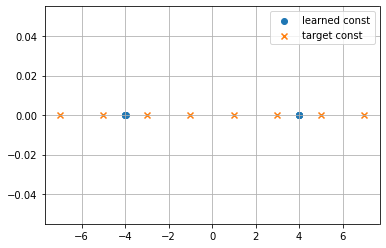

In [23]:
# Data for the plots
A = get_labeling(range(M))
x_plot = classic_mapper(range(M), alphabet)
xhat_plot = mapper3(torch.tensor(A).float()).detach().numpy()
# Plot
plt.scatter(np.real(xhat_plot),np.imag(xhat_plot), marker="o",label='learned const')
plt.scatter(np.real(x_plot),np.imag(x_plot), marker='x', label='target const')
plt.legend()
plt.grid()

* 5) For the input alphabet from 3), devise a non-linear neural network with $m$
inputs that approximates the mapping $\boldsymbol{b}(a) \mapsto x_a$ well w.r.t. the MSE loss.

In [25]:
class Mapper4(nn.Module):
    def __init__(self, m, width):
        super().__init__()
        self.lin1 = nn.Linear(m, width)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(width, width)
        self.act2 = nn.ReLU()
        self.lin3 = nn.Linear(width, 1)
        
    def forward(self, y):
        y = self.act1(self.lin1(y))
        y = self.act2(self.lin2(y))
        return self.lin3(y)

In [35]:
m = 3
nn_width = 10
x_t = torch.tensor(x.reshape(-1,1)).float()
bits = get_labeling(a)
bits_t = torch.tensor(bits).float()
# Initialize network
mapper4 = Mapper4(m, nn_width)
# loss function
loss_fn = nn.MSELoss()
# Optimizer
optimizer = optim.Adam(mapper4.parameters(), lr=0.1)
# Training loop
for j in range(1000):
    x_hat = mapper4(bits_t)
    loss = loss_fn(x_hat, x_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Printout and visualization
    if j % 100 == 0:
        print(f'epoch {j}: Loss = {loss.detach().numpy() :.4f}')
    if loss < 1e-3:
        break

epoch 0: Loss = 20.9300
epoch 100: Loss = 0.0160


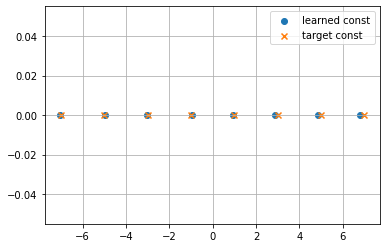

In [36]:
# Data for the plots
A = get_labeling(range(M))
x_plot = classic_mapper(range(M), alphabet)
xhat_plot = mapper4(torch.tensor(A).float()).detach().numpy()
# Plot
plt.scatter(np.real(xhat_plot),np.imag(xhat_plot), marker="o",label='learned const')
plt.scatter(np.real(x_plot),np.imag(x_plot), marker='x', label='target const')

plt.legend()
plt.grid()

##### Problem 6.2 
Consider the channel in the picture.
* 1) Implement the channel as differentiable function supporting torch.autograd using functions provided by torch
* 2) Use a linear neuron with $M$ inputs and one output as transmitter and a linear neuron with one input and M outputs as receiver. 
Sample a message $a \in  \{0,1, \dots, M-1 \}$ and use its one-hot representation $\boldsymbol{u}$ as transmitter input. 
Train transmitter and receiver w.r.t. the cross equivocation $ce(\boldsymbol{u}, \boldsymbol{\ell})$, where $\boldsymbol{\ell}$ is the receiver output.
* 3) Plot the learned channel input alphabet and compare it to the scatterplot of the channel output.

In [37]:
# Channel 
def tanh_channel(x, sigma2, seed=None):
    noise_t = sigma2*torch.randn(len(x),1)
    return torch.add(torch.tanh(x), noise_t)
    #return torch.tanh(x)
#TODO: make it wotk also with additive noise

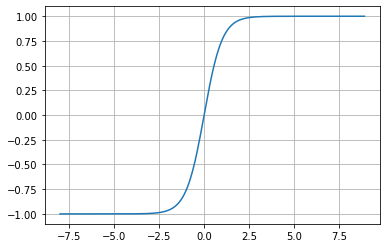

In [41]:
x = np.arange(-8,9,0.1)
plt.plot(x, np.tanh(x))
plt.grid()

In [42]:
# Transmitter and receiver NNs
class Transmitter(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(M, 1)

    def forward(self, y):
        y = self.lin1(y)
        return y
    
class Receiver(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, M)

    def forward(self, y):
        y = self.lin1(y)
        return y    

In [50]:
# Create data
n = 100000
snrdB = 20
snr = 10**(snrdB/10)
sigma2 = 1/snr
print(M)
a = np.random.choice(range(M), size=n)
onehot = np.array([one_hot(a[i], M) for i in range(n)])

8


In [44]:
# Initialize networks
tx = Transmitter(M)
rx = Receiver(M)
# Loss function
loss_fn = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(list(tx.parameters()) + list(rx.parameters()), lr=0.1)

In [45]:
 # Batches
batch_size = 100
onehot_t = torch.tensor(onehot).float()
a_t = torch.tensor(a)
a_t = a_t.type(torch.LongTensor)

In [46]:
# Training loop
for j in range(10000):
    x = tx(onehot_t)
    y = tanh_channel(x, sigma2).float()
    l = rx(y)
    loss = loss_fn(l, a_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Printout and visualization
    if j % 1000 == 0:
        print(f'epoch {j}: Loss = {loss.detach().numpy() :.4f}')
    if loss < 1e-3:
        break

epoch 0: Loss = 2.2619
epoch 1000: Loss = 0.4152
epoch 2000: Loss = 0.2179
epoch 3000: Loss = 0.1913
epoch 4000: Loss = 0.1818
epoch 5000: Loss = 0.0323
epoch 6000: Loss = 0.0165
epoch 7000: Loss = 0.0118
epoch 8000: Loss = 0.0082
epoch 9000: Loss = 0.0055


In [47]:
# Data for the plots
a_plot = np.arange(M)
onehot_plot = np.array([one_hot(a_plot[i], M) for i in range(M)])
learned_x = tx(torch.tensor(onehot_plot).float())
yy_plot = torch.tanh(learned_x)

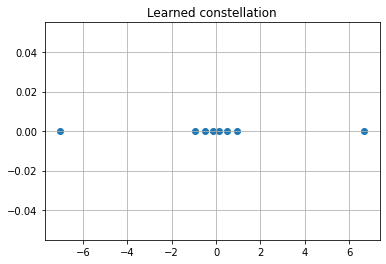

In [48]:
# Plot
plt.scatter(np.real(learned_x.detach().numpy()), np.imag(learned_x.detach().numpy()))
plt.title('Learned constellation')
plt.grid()

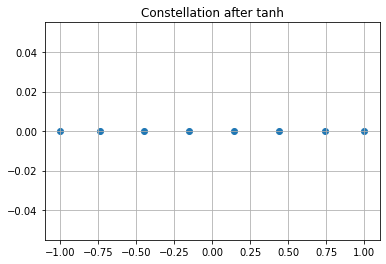

In [49]:
plt.scatter(np.real(yy_plot.detach().numpy()), np.imag(yy_plot.detach().numpy()))
plt.title('Constellation after tanh')
plt.grid()

In [53]:
# Create test data
n = 100000
a_test = np.random.choice(range(M), size=n)
onehot = np.array([one_hot(a_test[i], M) for i in range(n)])
x_test = tx(a) # mapped symbols
y_test = tanh_channel(x_test, sigma2).float()
x_hat_test = rx(y_test)

TypeError: ignored

In [51]:
# Plot
plt.scatter(np.real(x_test), np.imag(x_test))
plt.title('Learned constellation')
plt.grid()

NameError: ignored